# Faktoren und deren Einfluss auf die Visaantragsannahme

Im Folgenden soll ein genauer Blick auf die angenommenen oder abgelehnten Visaanträge geworfen werden und Faktoren ausfindig gemacht werden, welche die Annahme eines Visaantrages beeinflussen.

In [1]:
import cleanup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import modules

#plt.style.use('../own_style.mplstyle')

In [2]:
# cleanup.generate_cleaned_df()


In [3]:
col_list = ["case_status", "country_of_citizenship","employer_name" ,"employer_city", "foreign_worker_info_education", "prevailing_wage_level_9089", "prevailing_wage_soc_title", "prevailing_wage_amount_9089", "prevailing_wage_unit_of_pay_9089", "us_economic_sector", "class_of_admission"]
visas_df = pd.read_csv('../data/us_perm_visas_cleaned.csv', usecols=col_list)

C:\Users\andre\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Zuerst werden die vorhandenen Daten angesehen.

<AxesSubplot:title={'center':'Case Status Distribution'}, ylabel='Case Status'>

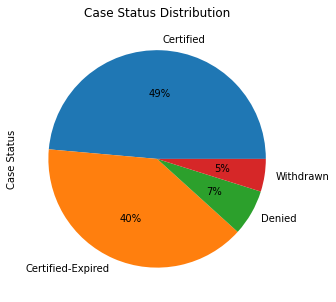

In [4]:
visas_df["case_status"].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=[15,5], ylabel = "Case Status", title = "Case Status Distribution")

Die vorhandenen Werte sollen kurz erklärt werden. Die Erklärungen dafür wurden im Internet gefunden.

- Certified:
    - A “certified” status indicates the labor certification is granted. The certified application and a complete Final Determination form will be sent to the employer, or, if appropriate, to the employer’s agent or attorney, indicating the employer may file all the documents with the appropriate office in the Department of Homeland Security (DHS).
    - https://www.usavisanow.com/perm/perm-faq/perm-online-status-indicators/
    - PERM certified status means it has been approved and is valid for 180 days from the date of approval.
    - https://www.am22tech.com/uscis/perm-processing-time/
- Certified-Expired:
    - After the Labor Certification is approved by the DOL, an Immigrant Petition related to the Labor Certification should be filed with the U.S.C.I.S. before the expiration of the labor certification. The certification has a validity period of 180-days and expires if not submitted to USCIS within this period.
    - https://immsolutionsllc.com/work-visas/perm-labor-certification
    - PERM certified expired means that PERM was approved but was not used within 6 months to file i140 with USCIS.
    - https://www.am22tech.com/uscis/perm-processing-time/
- Denied:
    - A “denied” status indicates the application is denied. A Final Determination form, stating the reasons for the determination and advising the employer of how to request review, should the employer choose to do so, will be sent to the employer. The Final Determination must be included in any request for review, therefore, the employer must wait to receive the form before making such a request. The employer is also advised to wait for the Final Determination before filing a new application for the same alien to avoid repeating errors made in the original application.
    - https://www.usavisanow.com/perm/perm-faq/perm-online-status-indicators/
    - PERM application was denied by DOL.
    - https://www.am22tech.com/uscis/perm-processing-time/
- Withdrawn:
    - A “withdrawn” status indicates the employer has withdrawn the application.
    - https://www.usavisanow.com/perm/perm-faq/perm-online-status-indicators/
    - PERM application was withdrawn by employer.
    - https://www.am22tech.com/uscis/perm-processing-time/

Regarding the analysis question, factors influencing the acceptance of applications, some changes eill be made in the dataset.

"Certified-Expired" will be changed into "Certified"
And columns containing "Withdrawn" will be deleted.

Um der Analysefrage nach Visaantragannahme oder -ablehnung näher zu kommen, werden Änderungen im Datensatz vorgenommen:
- "Certified-Expired" wird abgeändert zu "Certified"
- Datensätze, welche "Withdrawn" sind werden ersatzlos gelöscht


In [5]:
visas_df = cleanup.convert_case_status_to_certified_or_denied(visas_df)

Das Ergbnis der Datensatzänderungen soll visualisiert werden.

<AxesSubplot:title={'center':'Case Status Distribution'}>

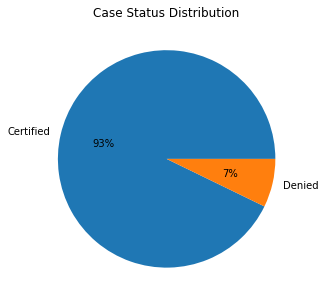

In [6]:
visas_df["case_status"].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=[15,5], ylabel = "", title = "Case Status Distribution")

<AxesSubplot:>

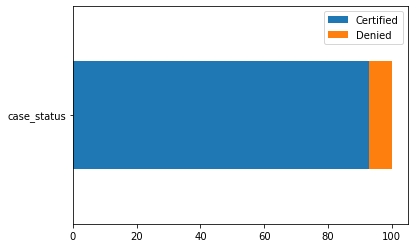

In [7]:
visas_df["case_status"].value_counts(normalize=True).mul(100).to_frame().T.plot.barh(stacked=True)

In [8]:
visas_df["case_status"].value_counts(normalize=True).mul(100)



Certified    92.798623
Denied        7.201377
Name: case_status, dtype: float64

Über den gesamten Anaylsebericht hinweg, soll der Medianwert als Referenzwert angezeigt werden.

In [9]:
median_certified_normalized = visas_df["case_status"].value_counts(normalize=True).mul(100).loc["Certified"]

In [10]:
median_certified_normalized

92.79862312167292

## Der Einfluss des Herkunftslandes

Hat das Herkunftsland einen Einfluss auf die Visaentscheidung?

Hier soll ein Blick auf die 20 am meist im Datensatz vertretenen Herkunftsländer geworfen werden.

In [11]:
top20 = visas_df["country_of_citizenship"].value_counts().nlargest(20).reset_index()

top20.columns = ['country_of_citizenship', 'count']

top20 = top20.set_index(['country_of_citizenship'])

In [12]:
top20.head(20)

,count
country_of_citizenship,
INDIA,196585
CHINA,27454
SOUTH KOREA,22254
CANADA,14109
MEXICO,8564
PHILIPPINES,8182
UNITED KINGDOM,4714
TAIWAN,3944
PAKISTAN,3776


Die 20 am häufgisten vorkommenden Herkunftsländer sind:

<AxesSubplot:xlabel='country_of_citizenship'>

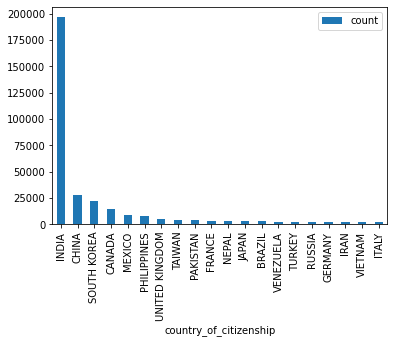

In [13]:
top20.plot.bar()

Alle Einträge, welche nicht mit den 20 am häufigsten vorkommenden Länder verbunden sind, werden aus dem Analysedatensatz dieser Fragestellung verworfen.
Der Analysedatensatz ist df_top.

In [14]:
df_top = visas_df.loc[visas_df['country_of_citizenship'].isin(top20.reset_index()['country_of_citizenship'])]

Es gibt große Unterschiede in der absoluten Anzahl der Visaanträge zwischen den verschiedenen Herkunftländer.
So ist Indien viel häufiger im Datensatz vertreten, alls alle anderen Herkunftsländer.

Um die verschiedenen Herkunftsländer miteinander vergleichen zu können, wechseln wir in der Analyse von absoluten auf relative Kennzahlen.

In [15]:
df_top_normalized_case_status = df_top["case_status"].groupby(df_top["country_of_citizenship"]).value_counts(normalize=True).mul(100).reset_index(name='counts')

In [16]:
df_top_normalized_case_status.head()

,country_of_citizenship,case_status,counts
0,BRAZIL,Certified,90.547798
1,BRAZIL,Denied,9.452202
2,CANADA,Certified,93.691970
3,CANADA,Denied,6.308030
4,CHINA,Certified,94.172070


Nun pivotieren wir die entstandene Tabelle in ein anderes Format um, um die Ausgabe als gestaffeltes Balkendiagramm zu ermöglichen.

In [17]:
df_top_normalized_case_status = df_top_normalized_case_status.pivot(index="country_of_citizenship", columns = "case_status", values = "counts")

In [18]:
df_top_normalized_case_status.head()

case_status,Certified,Denied
country_of_citizenship,,
BRAZIL,90.547798,9.452202
CANADA,93.691970,6.308030
CHINA,94.172070,5.827930
FRANCE,94.131223,5.868777
GERMANY,94.289509,5.710491


Wir werden der Vollständigkeit halber noch die absoluten Kennzahlen je Land hinzufügen.

In [19]:
df_top_normalized_case_status = df_top_normalized_case_status.merge(top20, left_on='country_of_citizenship', right_on='country_of_citizenship')
df_top_normalized_case_status = df_top_normalized_case_status.sort_values(by=['count'], ascending=False)

df_top_normalized_case_status.head()

,Certified,Denied,count
country_of_citizenship,,,
INDIA,95.158328,4.841672,196585
CHINA,94.172070,5.827930,27454
SOUTH KOREA,88.384111,11.615889,22254
CANADA,93.691970,6.308030,14109
MEXICO,76.389538,23.610462,8564


Es folgt die Ausgabe als gestaffeltes Balkendiagramm.

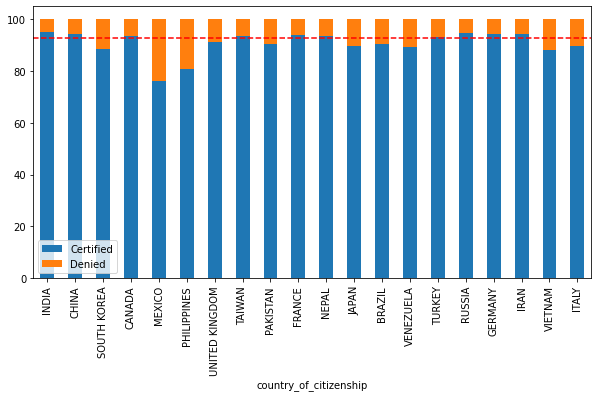

In [20]:
df_top_normalized_case_status[['Certified','Denied']].plot.bar(stacked=True, figsize=(10,5))

plt.axhline(median_certified_normalized, color='r', linestyle='--')

plt.show()

Es lässt sich festhalten, dass insbesondere Bewerber aus Mexiko und Vietnam häufiger abgelehnt werden, als die restlichen Herkunftsländer.
Es scheint, als hätte das Herkunftsland durchaus einen Einfluss auf die Visaentscheidung.

## Der Arbeitgeber als Einflussfaktor

In [21]:
visas_df["employer_name"].value_counts()

COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION    11936
MICROSOFT CORPORATION                             8082
INTEL CORPORATION                                 6120
GOOGLE INC.                                       5060
AMAZON CORPORATE LLC                              3639
                                                 ...  
BELLY MOTIONS, INC.                                  1
GREGS IRON WORK, INC.                               1
1-STOP TRANSLATION USA                               1
3 TIGER MARTIAL ARTS CORPORATION                     1
CHARLES RIVER APPAREL                                1
Name: employer_name, Length: 69576, dtype: int64

In [22]:

def influence_on_acceptance_stacked_bar_chart(dataFrameToAnalyze = pd.DataFrame, invokesInfluence = str, isInfluencedBy = str, top = int, binnedData = False):

    #top columns of invokesInfluence
    topDf = dataFrameToAnalyze[invokesInfluence].value_counts().nlargest(top).reset_index()
    topDf.columns = [invokesInfluence, 'count']
    topDf = topDf.set_index([invokesInfluence])
    df_top = dataFrameToAnalyze.loc[dataFrameToAnalyze[invokesInfluence].isin(topDf.reset_index()[invokesInfluence])]


    df_top_normalized_case_status = df_top[isInfluencedBy].groupby(df_top[invokesInfluence]).value_counts(normalize=True).mul(100).reset_index(name='counts')

    df_top_normalized_case_status = df_top_normalized_case_status.pivot(index=invokesInfluence, columns = isInfluencedBy, values = "counts")

    df_top_normalized_case_status = df_top_normalized_case_status.merge(topDf, left_on=invokesInfluence, right_on=invokesInfluence)



    if binnedData == True:
        df_top_normalized_case_status = df_top_normalized_case_status.sort_values(by=[invokesInfluence], ascending=False)
    else:
        df_top_normalized_case_status = df_top_normalized_case_status.sort_values(by=['count'], ascending=False)


    df_top_normalized_case_status = df_top_normalized_case_status.fillna(0)
    #print(df_top_normalized_case_status.head())



    legend = list(df_top_normalized_case_status.loc[:, df_top_normalized_case_status.columns != 'count'].columns)

    #df_top_normalized_case_status[dataFrameToAnalyze[isInfluencedBy].unique()].plot.bar(stacked=True, figsize=(10,5))
    df_top_normalized_case_status[legend].plot.bar(stacked=True, figsize=(10,5))

    plt.axhline(median_certified_normalized, color='r', linestyle='--')

    plt.show()

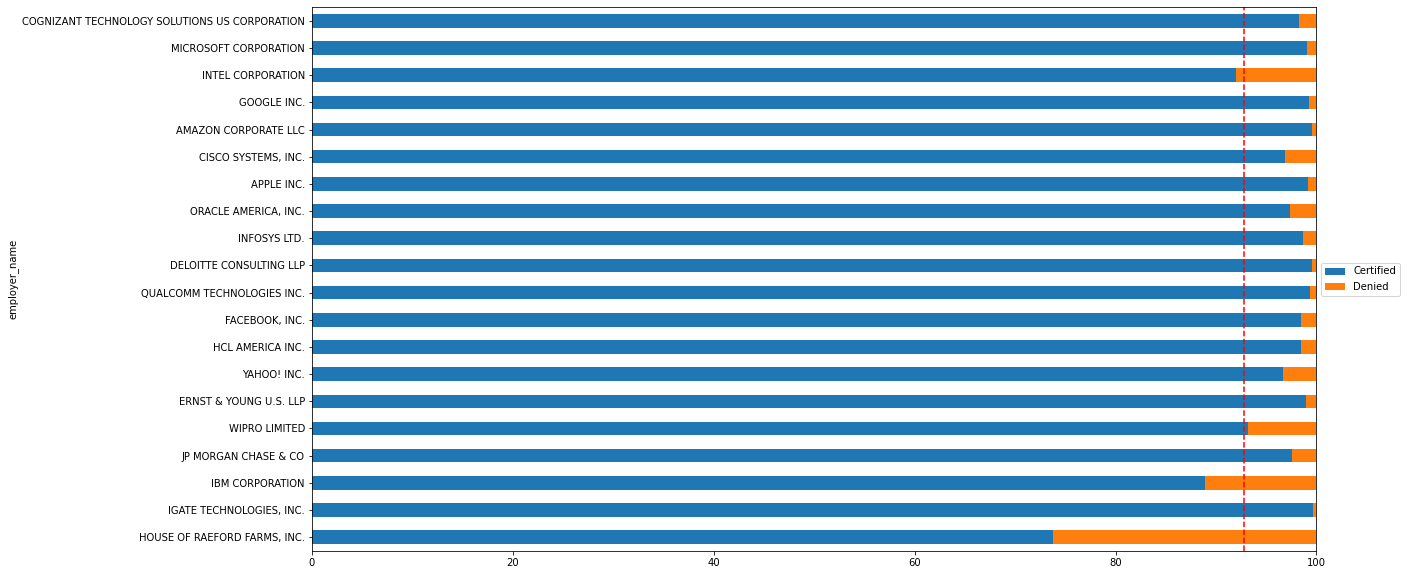

In [23]:
modules.invokes_influence_is_influenced_by_stacked_bar_chart(visas_df, "employer_name", "case_status", 20, 20, medianLineInt=median_certified_normalized, barh = True)

Interpretationshilfe:
Die Arbeitgeber sind absteigend der Anzahl an vorhandenen Datensätze angeordnet.
Ein Balken spielt 100% der vorhandenen Datensätze je Arbeitgeber dar.
Dieser Balken kann durch den angegebenen Status relativ aufgeteilt werden. In diesem Fall in das Verhältnis "Certified" und das Verhältnis "Denied".

Die Anträge von Amazon, werden viel öfter als der Durschnitt angenommen, ebenso bei Google.
Das kann verschiedene Gründe haben.

- Der US Regierung ist bewusst, dass diese Unternehmen internationale Aushängeschilder sind. Deswegen werden diese Unternehmen bevorzugt.
- Amazon und Google stellen nur Anträge, wenn diese inhaltlich korrekt sind und sie sich sicher sind, dass diese angenommen werden.

Es soll noch kurz auf die Funktion "invokes_influenced_is_influenced_by_stacked_bar_chart" der modules.py eingegangen werden:
modules.invokes_influenced_is_influenced_by_stacked_bar_chart(visas_df, "employer_name", "case_status", 30, 20, medianLineInt=median_certified_normalized, barh = True)

An erster Stelle, wird das genutzte DataFrame Objekt übergeben.
Die zweite Stelle beeinhaltet den Spaltennamen, welcher als Einflussfaktor vermutet "invokesInfluence"
Die dritte Stelle beeinhaltet den Spaltennamen, welcher mutmaßlich durch den Einflussfaktoren beeinflusst wird "isInfluencedBy"
Die vierte Stelle ist ein Integer Wert, welcher die maximale Anzahl an Einflussfaktor-Werten begrenzt. Es werden hier maximal 20 Einflussfaktor-Werte (Arbeitgeber) ausgegeben.
Die fünfte Stelle ist ein Integer Wert, welcher die maximale Anzahl der beeinflussten Werte begrenzt. Es werden hier maximal 20 beeinflusste Werte (Case Status) ausgegeben. Allerdings liegen in diesem Fall nur 2 bveeinflusste Werte vor (Certified oder Denied).
Die sechte Stelle fordert die Anzeige einer Medianlinie an. Diese Medianlinie liegt bei `median_certified_normalized`.
Die siebte Stelle fordert die Ausgabe in Form eines horzontalen Balkendiagramms an. Dies wurde gewählt um die Lesbarkeit zu vereinfachen.

## Die Arbeitgeberstadt als Einflussfaktor

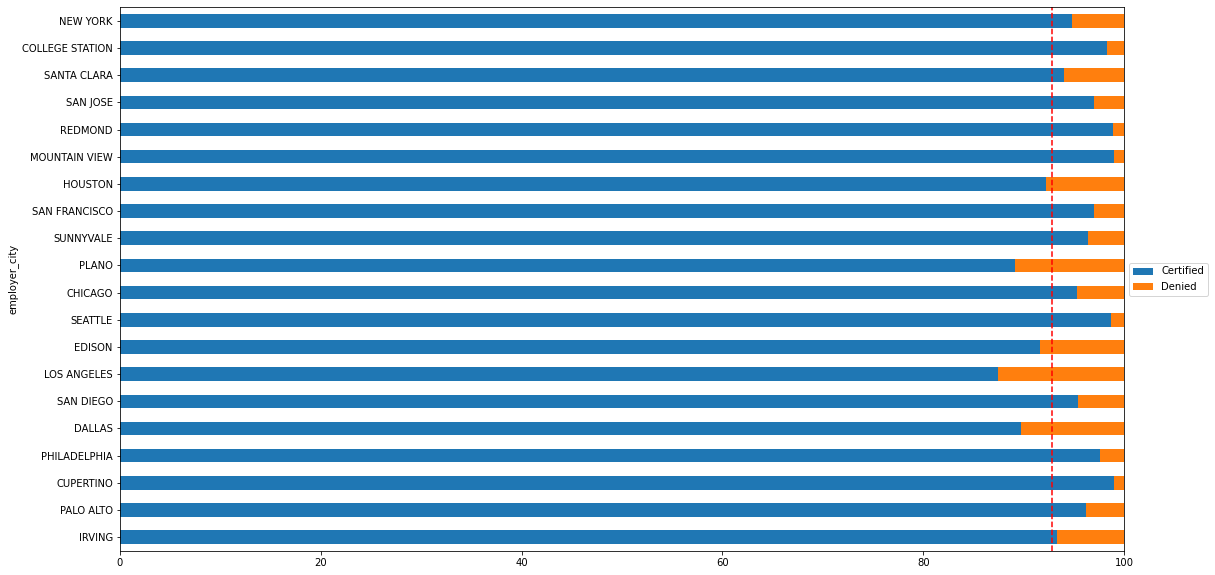

In [24]:
modules.invokes_influence_is_influenced_by_stacked_bar_chart(visas_df, "employer_city", "case_status", 20, 20, medianLineInt=median_certified_normalized, barh = True)

Anträge, bei denen die Arbeitgeber in den Städten Redmond, Mountain View oder College Station ansässig sind, werden eher angenommen, als beim Durschnitt.
Dies lässt sich gut durch die ansässigen Arbeitgeber erklären.

In [25]:
print(visas_df[visas_df["employer_city"]=="MOUNTAIN VIEW"]["employer_name"].value_counts()[:5])
print("")
print(visas_df[visas_df["employer_city"]=="REDMOND"]["employer_name"].value_counts()[:5])
print("")
print(visas_df[visas_df["employer_city"]=="COLLEGE STATION"]["employer_name"].value_counts()[:5])

GOOGLE INC.             5060
LINKEDIN CORPORATION     655
SYMANTEC CORPORATION     480
SYNOPSYS, INC.           414
INTUIT                   383
Name: employer_name, dtype: int64

MICROSOFT CORPORATION    8082
ILINK SYSTEMS, INC.        42
NOKIA INC.                 40
LENORA SYSTEMS INC         40
ALSTOM GRID, INC.          35
Name: employer_name, dtype: int64

COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION    11894
TEXAS A&M UNIVERSITY                                60
TEXAS TRANSPORTATION INSTITUTE                       5
STATACORP, LP                                        5
KNOWLEDGE BASED SYSTEMS, INC.                        4
Name: employer_name, dtype: int64


Diese Städte sind das Hauptquartier von Firmen internationaler Bekanntheit.
- Mountain View: GOOGLE INC.
- Redmond: MICROSOFT CORPORATION
- College Station: COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION

## Der Bildungsabschluss als Einflussfaktor

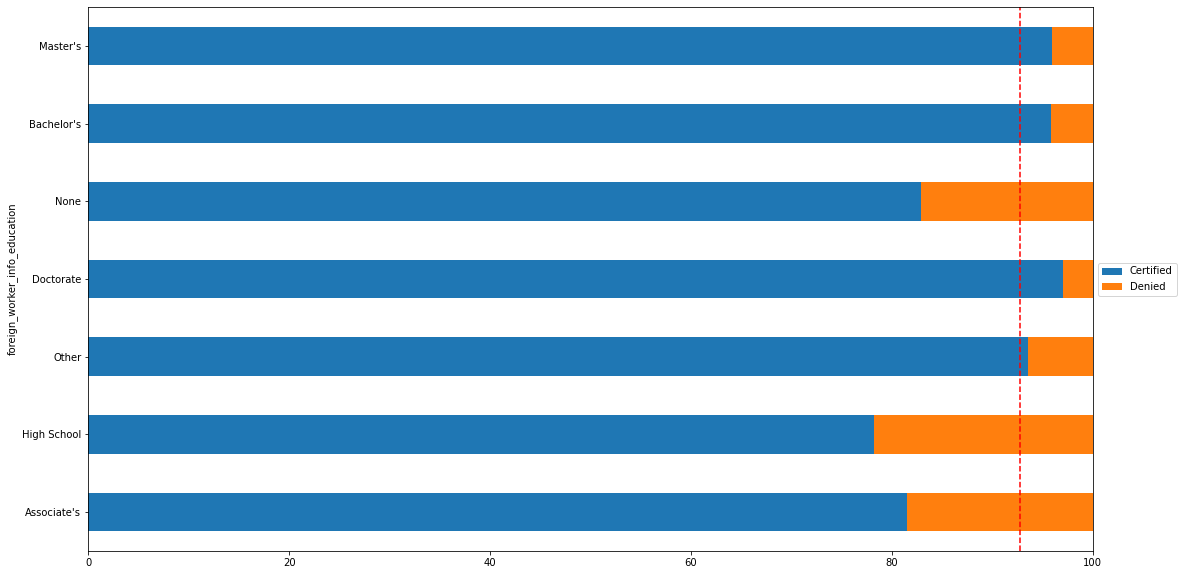

In [26]:

modules.invokes_influence_is_influenced_by_stacked_bar_chart(visas_df, "foreign_worker_info_education", "case_status", 20, 20, medianLineInt=median_certified_normalized, barh = True)

Der Bildungsaschluss ist ein starker Einflussfaktor.
So beeinflussen die höchsten Bildungsabschlüsse Bachelor, Master, Doctorate, die Annahmequote positiv.
Geringere Bildungsabschlüsse wie None, High School und Associate werden dagegen öfter als der Durchschnitt abgelehnt.

## Die ermittelte übliche Lohnklasse als Einflussfaktor

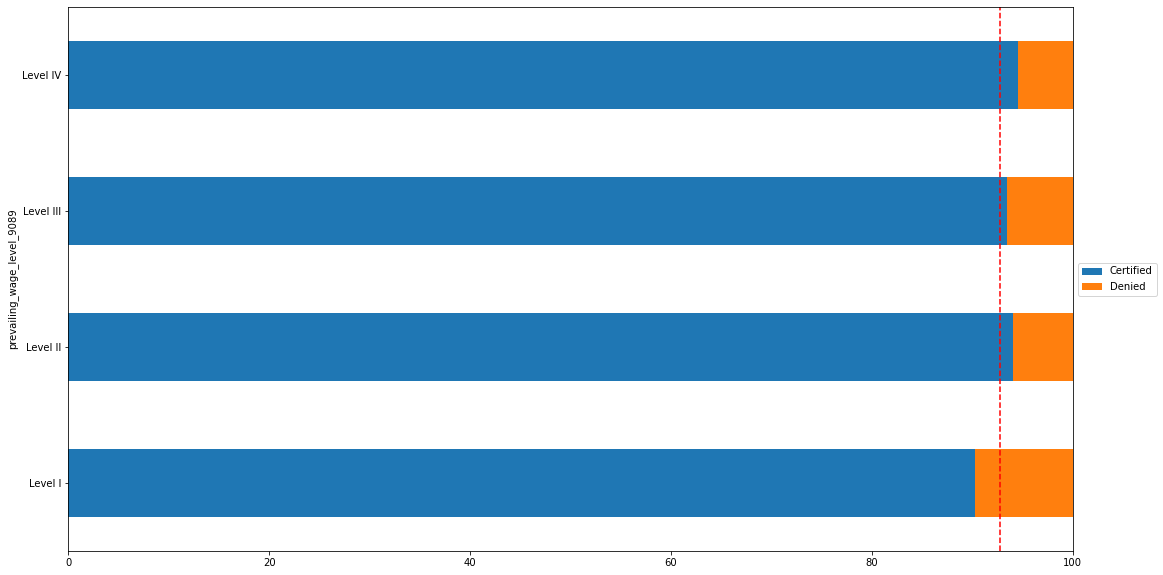

In [27]:
modules.invokes_influence_is_influenced_by_stacked_bar_chart(visas_df, "prevailing_wage_level_9089", "case_status", 20, 20, medianLineInt=median_certified_normalized, barh = True, sortAlphabetically = True)


## Die gewählte Jobbezeichnung im Rahmen der Ermittlung des üblichen Lohnes als Einflussfaktor

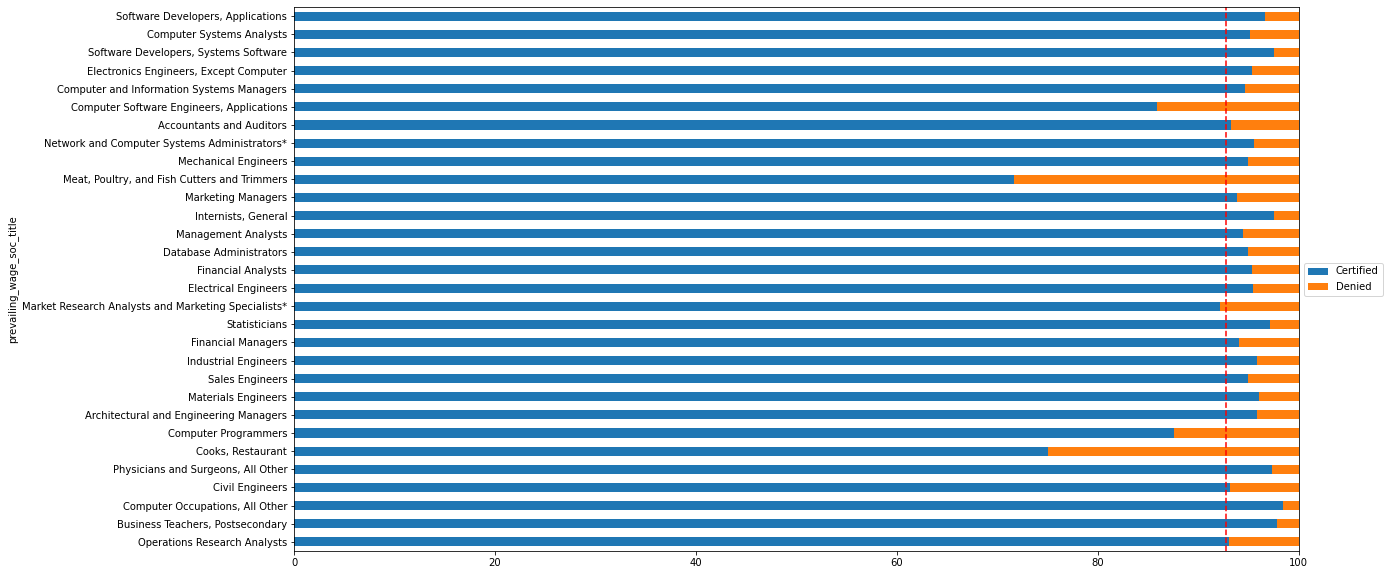

In [28]:
modules.invokes_influence_is_influenced_by_stacked_bar_chart(visas_df, "prevailing_wage_soc_title", "case_status", 30, 20, medianLineInt=median_certified_normalized, barh = True)


Fleischverarbeiter und Köche werden vergleichsweise oft im Visaprozess abgelehnt.

## Der ermittelte übliche Lohn als Einflussfaktor


Hierfür muss vorab der Datensatz bereinigt werden.
Um eine Vergleichbarkeit herzustellen, werden wir nun Löhne visualisieren, deren Einheit das Jahr ist.
Diese Einheit kommt auch im Datensatz am meisten vor.

In [29]:
visas_df["prevailing_wage_unit_of_pay_9089"].value_counts()

yr     346706
hr       7638
wk        195
mth       121
bi         27
Name: prevailing_wage_unit_of_pay_9089, dtype: int64

In [30]:
wage_df = visas_df[visas_df["prevailing_wage_unit_of_pay_9089"].str.contains("yr", na=False)]

In [31]:
wage_df["prevailing_wage_amount_9089"] = wage_df["prevailing_wage_amount_9089"].fillna(0).astype(int)


Die ermittelte üblichen Löhne werden in 20 Kategorien (Bins) gleicher Anzahl aufgeteilt.
So beeinflussen unter anderem auch Outliers das Auswertungsergebnis weniger stark.

In [32]:
wage_df['prevailing_wage_amount_9089_bins'] = pd.qcut(wage_df['prevailing_wage_amount_9089'], q=20)


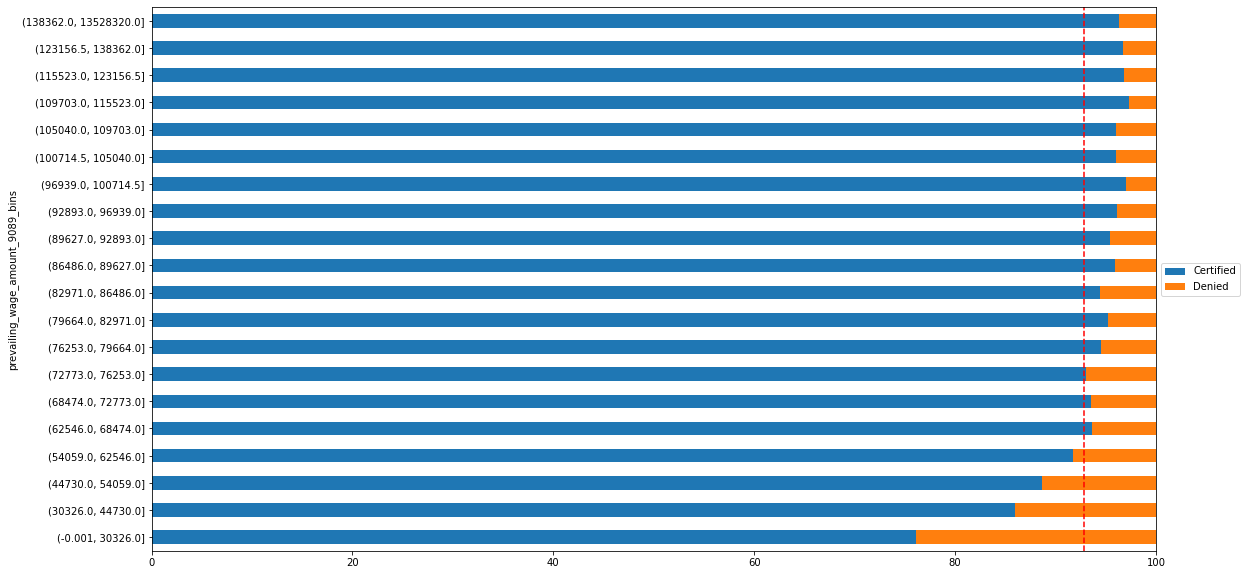

In [33]:
modules.invokes_influence_is_influenced_by_stacked_bar_chart(wage_df, "prevailing_wage_amount_9089_bins", "case_status", 20, 20, medianLineInt=median_certified_normalized, barh = True, sortAlphabetically = True)


Das ermittelte übliche Einkommen hat tatsächlich Einfluss auf die Annahme des Visaantrages. Es ist zu erkennen, dass Visaanträge ab einem Einkommen von ca. 86.000€ USD im Jahr gleichbehandelt werden.

## Der US Wirtschaftssektor als Einflussfaktor

Wie in einwandererArbeitgeber.ipynb bereits festgehalten sind die Sektoren, so wie sie im Datensatz vorhanden sind noch nicht zur Analyse geeignet.
Die Bereinigungsschritte aus einwandererArbeitgeber.ipynb wurde hier übernommen und deswegen an dieser Stelle nicht erneut erläutert.

In [34]:
new_sectors = visas_df["us_economic_sector"].groupby(visas_df["employer_name"]).value_counts(dropna=False
       ).reset_index(name='counts')


In [35]:
new_sectors = new_sectors[ new_sectors["us_economic_sector"].isna() == False]

In [36]:
new_sectors = new_sectors[new_sectors.groupby(["employer_name"])['counts'].transform(max) == new_sectors['counts']].reset_index(drop=True)
new_sectors = new_sectors.drop_duplicates(subset=['employer_name'])



In [37]:
del new_sectors["counts"]

In [38]:
new_sectors = new_sectors.rename(columns={"us_economic_sector": "us_economic_sector_cleaned"})

In [39]:
sectors_df = visas_df.merge(new_sectors, left_on = "employer_name", right_on="employer_name").reset_index(drop=True)

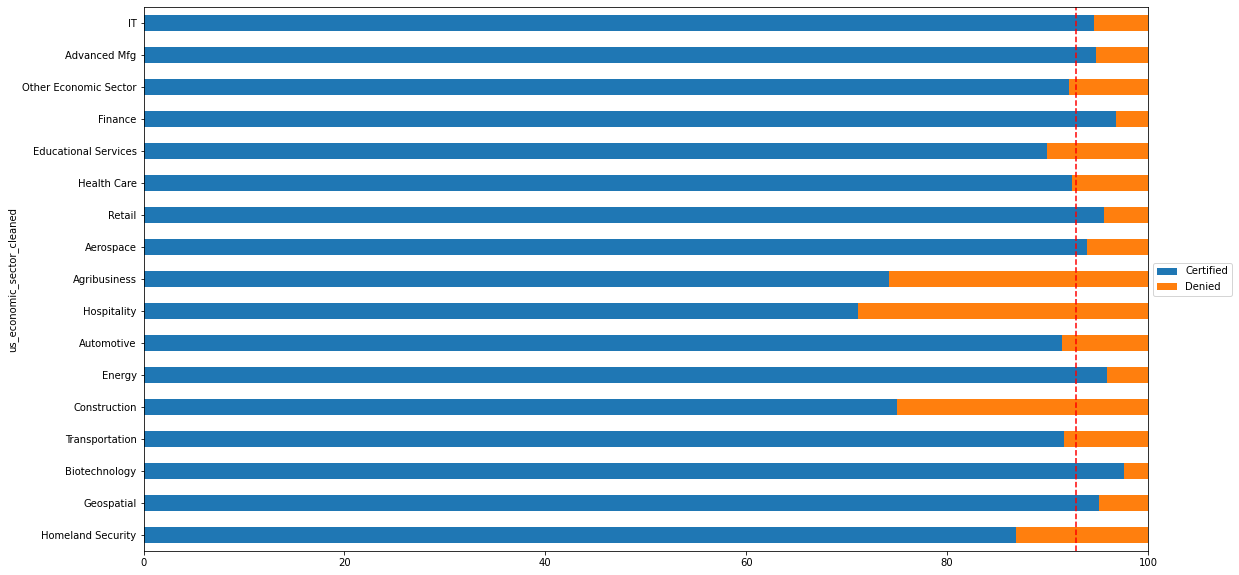

In [41]:
modules.invokes_influence_is_influenced_by_stacked_bar_chart(sectors_df, "us_economic_sector_cleaned", "case_status", 20, 20, medianLineInt=median_certified_normalized, barh = True)



## Die Visaart als Einflussfaktor

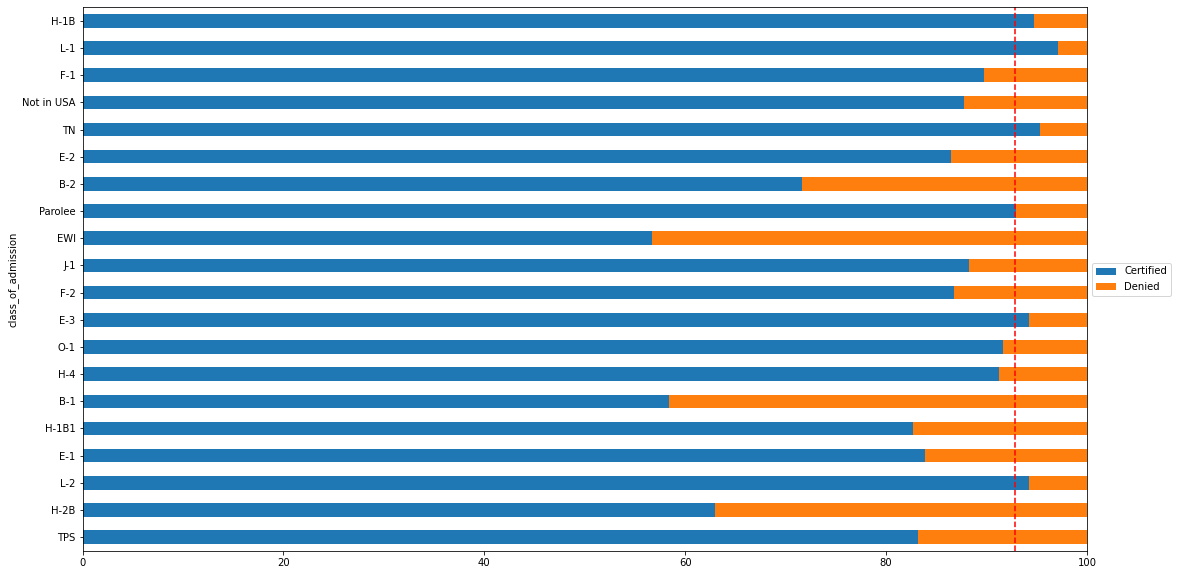

In [63]:
modules.invokes_influence_is_influenced_by_stacked_bar_chart(visas_df, "class_of_admission", "case_status", 20, 20, medianLineInt=median_certified_normalized, barh = True)

